In [2]:
!nvidia-smi

Fri Aug  4 15:07:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/pulmonary_abnormalities_project/CXTP_Dataset_224x224_aug_split.zip

Archive:  /content/drive/MyDrive/pulmonary_abnormalities_project/CXTP_Dataset_224x224_aug_split.zip
   creating: CXTP_Dataset_224x224_aug_split/
   creating: CXTP_Dataset_224x224_aug_split/test/
   creating: CXTP_Dataset_224x224_aug_split/test/NORMAL/
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_105_7211202.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_114_3230170.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_115_7652429.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_118_3911616.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_119_831410.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_145_9447791.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_149_9244358.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_153_6900085.jpg  
  inflating: CXTP_Dataset_224x224_aug_split/test/NORMAL/emotion_158_3481809.jpg  
  inflating

## Importing the Libraries

In [5]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.utils import to_categorical
import random
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Importing the Dataset

In [6]:
# Define Constants by re-sizing all the images
IMAGE_SIZE = [224, 224]

train_path = '/content/CXTP_Dataset_224x224_aug_split/train'
valid_path = '/content/CXTP_Dataset_224x224_aug_split/val'

#### Inception V3

In [7]:
# Import the InceptionV3 model and here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [8]:
# We don't need to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [9]:
# Folders in the Training Set
folders = glob('/content/CXTP_Dataset_224x224_aug_split/test/*')
folders

['/content/CXTP_Dataset_224x224_aug_split/test/TURBERCULOSIS',
 '/content/CXTP_Dataset_224x224_aug_split/test/NORMAL',
 '/content/CXTP_Dataset_224x224_aug_split/test/PNEUMONIA']

In [10]:
len(folders)

3

In [11]:
# Model layers -> can add more if required
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# Create a model object
model = Model(inputs=inception.input, outputs=prediction)

# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
# Defining the cost and model optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Using the Image Data Generator to import the images from the dataset  # to modify images like crop,rotate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Training Generator
training_set = train_datagen.flow_from_directory('/content/CXTP_Dataset_224x224_aug_split/train',
                                                 target_size = (224, 224),
                                                 batch_size = 512,
                                                 class_mode = 'categorical')

Found 1180 images belonging to 3 classes.


In [16]:
# Testing Generator
test_set = test_datagen.flow_from_directory('/content/CXTP_Dataset_224x224_aug_split/test',
                                            target_size = (224, 224),
                                            batch_size = 512,
                                            class_mode = 'categorical')

Found 128 images belonging to 3 classes.


In [17]:
test_set_len=175
batch_size=512

In [18]:
# fit the model, it will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-18-6fbbb713530a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
3/3 [==============================] - 47s 13s/step - loss: 11.5558 - accuracy: 0.4415 - val_loss: 19.4386 - val_accuracy: 0.3516
Epoch 2/20
3/3 [==============================] - 16s 5s/step - loss: 13.5089 - accuracy: 0.4186 - val_loss: 6.0464 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 16s 5s/step - loss: 8.4547 - accuracy: 0.5186 - val_loss: 10.0309 - val_accuracy: 0.6172
Epoch 4/20
3/3 [==============================] - 16s 4s/step - loss: 6.6160 - accuracy: 0.6390 - val_loss: 1.4965 - val_accuracy: 0.7422
Epoch 5/20
3/3 [==============================] - 15s 7s/step - loss: 5.3216 - accuracy: 0.5992 - val_loss: 5.2512 - val_accuracy: 0.5547
Epoch 6/20
3/3 [==============================] - 15s 7s/step - loss: 2.3866 - accuracy: 0.7441 - val_loss: 2.9382 - val_accuracy: 0.7031
Epoch 7/20
3/3 [==============================] - 15s 4s/step - loss: 3.4910 - accuracy: 0.6983 - val_loss: 2.8188 - val_accuracy: 0.7344
Epoch 8/20
3/3 [=============

## Visualize the model training by plotting Loss Function and Accuracy

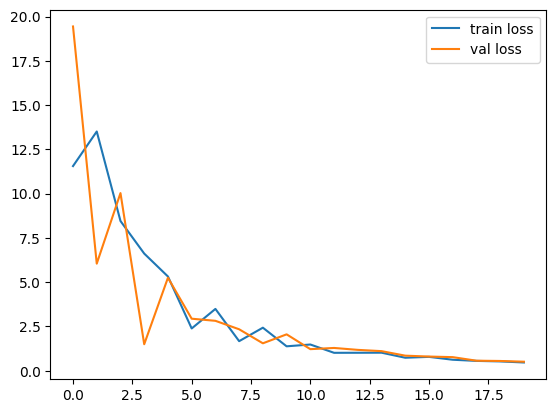

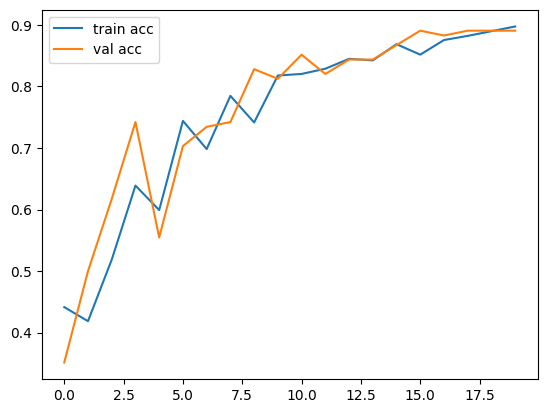

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the Loss and Accuracy
# Loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
# Saving the model as a h5 file

from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/pulmonary_abnormalities_project/model/model_inception.hdf5')

In [ ]:
li=['NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

Following is our prediction:
1/1 [==============================] - 0s 27ms/step


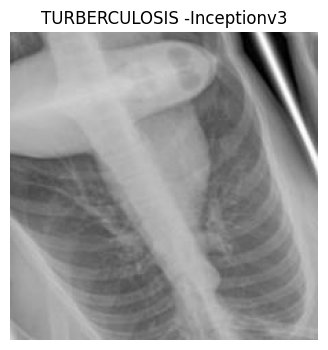

In [ ]:
# predicting an image
from keras.preprocessing import image
import keras.utils as image
import numpy as np
image_path = "/content/CXTP_Dataset_224x224_aug_split/test/TURBERCULOSIS/emotion_10_5491323.jpg"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
# img_class = classifier.predict_classes(img)
# img_prob = classifier.predict_proba(img)
# print(img_class ,img_prob )


#ploting image with predicted class name
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name+ " -Inceptionv3")
plt.show()

# New Section

In [ ]:
y_pred = model.predict(test_set)
y_pred

1/1 [==============================] - 1s 1s/step


array([[9.99988317e-01, 1.17266718e-05, 5.39464758e-19],
       [7.69290146e-16, 2.56724167e-13, 1.00000000e+00],
       [2.08090182e-19, 5.86723668e-20, 1.00000000e+00],
       [8.40059202e-03, 9.91599441e-01, 2.63683712e-22],
       [2.65772454e-03, 9.97342288e-01, 9.64761816e-20],
       [3.15037498e-04, 9.99684930e-01, 1.01262682e-23],
       [9.57835800e-06, 9.99990463e-01, 2.86246721e-14],
       [1.17070025e-08, 1.00000000e+00, 3.71497153e-21],
       [1.24777900e-03, 9.98752236e-01, 1.07420533e-16],
       [7.97889173e-01, 2.02110782e-01, 1.80025217e-24],
       [1.75155688e-03, 9.98248458e-01, 1.18096743e-15],
       [6.98086619e-02, 5.24596311e-02, 8.77731681e-01],
       [3.19334060e-01, 6.80665970e-01, 3.08753410e-19],
       [9.99570668e-01, 4.29299253e-04, 4.81088802e-13],
       [9.99862909e-01, 1.37095427e-04, 2.02934503e-10],
       [2.52272487e-02, 9.74772811e-01, 1.08924965e-19],
       [7.01922363e-06, 9.99992967e-01, 4.12221289e-15],
       [3.03684808e-02, 2.32834

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 2, 0, 1, 2, 1,
       1, 0, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 0, 2,
       0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 0,
       1, 0, 2, 0, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 1,
       2, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 0, 2])